# 1. Link ATAC-seq peaks to expression 

The ATAC-seq gives information about peak intensities per sample and the RNA-seq gives gene expression levels per sample. Wen want to correlate between chromatin and expresion.

We will answer the questions:
- Does this regulatory region (peak) affect this gene?
- Is that relationship consistent across many samples?

Before starting, I want to make sure that ATAC-seq and the RNA-seq datasets align to enable further analysis.

In [1]:
import pandas as pd

# Loading the data
atac_peak_matrix = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")
atac_signal_matrix = atac_peak_matrix.iloc[:, 8:]  # dropping metadata columns
atac_transposed_df = atac_signal_matrix.T

rna_df = pd.read_csv("rna_filtered_abT_Tact_Stem.csv", index_col=0)
rna_df.T
rna_transposed_df = rna_df.T

from sklearn.preprocessing import StandardScaler
rna_scaled_array = StandardScaler().fit_transform(rna_transposed_df)
rna_scaled_df = pd.DataFrame(rna_scaled_array, index=rna_transposed_df.index, columns=rna_transposed_df.columns)

# Ensuring sample alignment
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]

We can only correlate ATAC and RNA from the same samples. That is why we did the sample alignment so that both matrices refer to the same cell type.

Before continuing we want to make sure that this alignment worked correctly.

In [2]:
# Making sure datasets are aligned
## Comparing shapes
print("ATAC shape:", atac.shape)
print("RNA shape:", rna.shape)

## Comparing indices
for sample_a, sample_r in zip(atac.index, rna.index):
    print(f"ATAC: {sample_a}  |  RNA: {sample_r}")

## Inspecting common samples 
print("Common samples used for correlation:")
print(list(common_samples))


ATAC shape: (28, 512595)
RNA shape: (28, 17535)
ATAC: preT.DN1.Th  |  RNA: preT.DN1.Th
ATAC: preT.DN2a.Th  |  RNA: preT.DN2a.Th
ATAC: preT.DN2b.Th  |  RNA: preT.DN2b.Th
ATAC: preT.DN3.Th  |  RNA: preT.DN3.Th
ATAC: T.DN4.Th  |  RNA: T.DN4.Th
ATAC: T.ISP.Th  |  RNA: T.ISP.Th
ATAC: T.DP.Th  |  RNA: T.DP.Th
ATAC: T.4.Th  |  RNA: T.4.Th
ATAC: T.8.Th  |  RNA: T.8.Th
ATAC: T.4.Nve.Sp  |  RNA: T.4.Nve.Sp
ATAC: T.4.Nve.Fem.Sp  |  RNA: T.4.Nve.Fem.Sp
ATAC: T.4.Sp.aCD3+CD40.18hr  |  RNA: T.4.Sp.aCD3+CD40.18hr
ATAC: T.8.Nve.Sp  |  RNA: T.8.Nve.Sp
ATAC: Treg.4.25hi.Sp  |  RNA: Treg.4.25hi.Sp
ATAC: Treg.4.FP3+.Nrplo.Co  |  RNA: Treg.4.FP3+.Nrplo.Co
ATAC: T8.TN.P14.Sp  |  RNA: T8.TN.P14.Sp
ATAC: T8.TE.LCMV.d7.Sp  |  RNA: T8.TE.LCMV.d7.Sp
ATAC: T8.MP.LCMV.d7.Sp  |  RNA: T8.MP.LCMV.d7.Sp
ATAC: T8.Tcm.LCMV.d180.Sp  |  RNA: T8.Tcm.LCMV.d180.Sp
ATAC: T8.Tem.LCMV.d180.Sp  |  RNA: T8.Tem.LCMV.d180.Sp
ATAC: NKT.Sp  |  RNA: NKT.Sp
ATAC: NKT.Sp.LPS.3hr  |  RNA: NKT.Sp.LPS.3hr
ATAC: NKT.Sp.LPS.18hr  |  RNA: NKT

We have established that the datasets align. 

Now, want to create a gene -> TSS coordinate table to be able to annotate the peaks later. We are using the annotations file (refFlat) for this step.

In [3]:
ref = pd.read_csv("refFlat", sep="\t", header=None)
ref.head()
ref.shape
len(ref)

47382

In [4]:
import pandas as pd
from scipy.spatial import cKDTree

# Loading and naming refFlat columns 
ref = pd.read_csv("refFlat", sep="\t", header=None)

ref.columns = [
    "gene_name", "transcript_id", "chrom", "strand",
    "tx_start", "tx_end", "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# Computing strand-aware TSS 
ref["tss"] = ref.apply(
    lambda row: row["tx_start"] if row["strand"] == "+" else row["tx_end"],
    axis=1
)

# Keeping one TSS per gene
tss_table = ref.groupby("gene_name").first().reset_index()
tss_table = tss_table[["gene_name", "chrom", "tss", "strand"]].rename(columns={"gene": "gene_symbol"})

print("TSS table shape:", tss_table.shape)
tss_table.head()


TSS table shape: (26214, 4)


,gene_name,chrom,tss,strand
0,0610005C13Rik,chr7,45575176,-
1,0610009B22Rik,chr11,51688634,-
2,0610009E02Rik,chr2,26445923,+
3,0610009L18Rik,chr11,120348677,+
4,0610010F05Rik,chr11,23633631,-


Now, we want to match ATAC peaks to nearest TSS. For that, we will find the nearest gene to each peak and compute the distance to that gene's TSS. We will use KD-Tree for this. It will give us information about which gene is likely regulated by which peak.

In [5]:
# Loading ATAC peak file
peaks = pd.read_csv("peaks_tss_distance.csv") 
peaks = peaks.rename(columns={"ImmGenATAC1219.peakID": "peak_id"})

# Create BED-style table 
peak_table = peaks[["peak_id", "chrom", "peak_center"]].copy()
peak_table["start"] = peak_table["peak_center"]
peak_table["end"] = peak_table["peak_center"] + 1  # peak summit +1 bp to make it computable

# Matching each peak to the nearest TSS
from scipy.spatial import cKDTree

tss_links = []

for chrom in peak_table["chrom"].unique():
    peaks_chr = peak_table[peak_table["chrom"] == chrom]
    tss_chr = tss_table[tss_table["chrom"] == chrom]

    if tss_chr.empty:
        continue

    # Using KDTree for fast nearest-neighbor matching
    tree = cKDTree(tss_chr["tss"].values.reshape(-1, 1))
    dists, idxs = tree.query(peaks_chr["peak_center"].values.reshape(-1, 1), k=1)

    matched_genes = tss_chr.iloc[idxs]["gene_name"].values
    matched_tss = tss_chr.iloc[idxs]["tss"].values
    matched_strands = tss_chr.iloc[idxs]["strand"].values

    result = peaks_chr.copy()
    result["gene_symbol"] = matched_genes
    result["tss"] = matched_tss
    result["strand"] = matched_strands
    
    # Computing signed distance to TSS based on strand
    result["signed_distance_to_tss"] = result.apply(
        lambda row: row["peak_center"] - row["tss"] if row["strand"] == "+" else row["tss"] - row["peak_center"],
        axis=1
    )

    # Keeping absolute value for safety
    result["distance_to_tss"] = result["signed_distance_to_tss"].abs()
    
    tss_links.append(result)

linked_df = pd.concat(tss_links, ignore_index=True)

# Saving result
linked_df.to_csv("peak_to_gene_annotated.csv", index=False)


The BED-style table refers to a table representing genomic features. It is used to standardize genomic region representation. Here, it represents ATAC peaks as genomic coordinated and matches each peak to the nearest TSS using spatial distance. This distance is computed as the difference between the peak summit and the TSS position on the same chromosome. We also added differentiation between up- and downstream elements. 

We can now link peaks to genes by correlating chromatin accessibility with gene expression across the 28 samples. Because there were a lot of errors that needed fixing, in this first cell I am reloading the datasets and aligning them again.

In [6]:
# Re-loading full ATAC matrix with metadata
full_atac = pd.read_csv("ATAC-seq/filtered_ATAC_abT_Tact_Stem.csv")

# Extracting signal matrix and assigning peak IDs as index
atac_signal_matrix = full_atac.iloc[:, 8:]  # signal: shape (512595 rows, 29 columns)
atac_signal_matrix.index = full_atac["ImmGenATAC1219.peakID"].astype(str)  # assigning to rows

# Transposing so rows = samples, columns = peak IDs
atac_transposed_df = atac_signal_matrix.T  # shape = (29 samples, 512595 peaks)

# Aligning with RNA
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]


In [7]:
print("Signal matrix shape (rows = peaks):", atac_signal_matrix.shape)
print("First 5 peak IDs (index):", atac_signal_matrix.index[:5].tolist())


Signal matrix shape (rows = peaks): (512595, 29)
First 5 peak IDs (index): ['ImmGenATAC1219.peak_1', 'ImmGenATAC1219.peak_2', 'ImmGenATAC1219.peak_3', 'ImmGenATAC1219.peak_4', 'ImmGenATAC1219.peak_5']


In [8]:
atac_transposed_df = atac_signal_matrix.T
common_samples = atac_transposed_df.index.intersection(rna_scaled_df.index)
atac = atac_transposed_df.loc[common_samples]
rna = rna_scaled_df.loc[common_samples]


In [9]:
import pandas as pd
from scipy.stats import spearmanr
from tqdm import tqdm

# Loading the peak–TSS annotated file with signed distances
annot = pd.read_csv("peak_to_gene_annotated.csv")

# Filtering to peaks within ±100 kb
annot = annot[annot["signed_distance_to_tss"].abs() <= 100000]

# Ensuring strings for matching
annot["peak_id"] = annot["peak_id"].astype(str)
annot["gene_symbol"] = annot["gene_symbol"].astype(str)
atac.columns = atac.columns.astype(str)
rna.columns = rna.columns.astype(str)

# Keeping only peak–gene pairs present in both matrices
filtered_map = annot[
    annot["peak_id"].isin(atac.columns) & 
    annot["gene_symbol"].isin(rna.columns)
]

# Correlating peak signal vs. gene expression across all samples
results = []

for _, row in tqdm(filtered_map.iterrows(), total=len(filtered_map)):
    peak = row["peak_id"]
    gene = row["gene_symbol"]
    dist = row["signed_distance_to_tss"]  # direction-aware

    try:
        rho, pval = spearmanr(atac[peak], rna[gene])
        results.append({
            "peak_id": peak,
            "gene_symbol": gene,
            "signed_distance_to_tss": dist,
            "spearman_rho": rho,
            "pval": pval
        })
    except Exception:
        continue

# Saving full results
cor_df = pd.DataFrame(results)
cor_df.to_csv("all_peak_gene_correlations.csv", index=False)

# Filtering for significant & strong correlations
linked_peaks = cor_df[
    (cor_df["pval"] < 0.05) & (cor_df["spearman_rho"].abs() > 0.5)
]
linked_peaks.to_csv("significant_peak_gene_links.csv", index=False)


100%|██████████| 9535461/9535461 [56:07<00:00, 2831.76it/s]  


In this code, filtered_map contains peak-gene pairs, that is same gene and peak existing in the data that are within +/- 100 kb of each other. For each pair we compute the genomic distance between the peak and the gene. 

The Spearman correlation compares the chromatin accessibility (ATAC) with the gene expression level (RNA) across samples and then computes the Spearman correlation coefficient (non-parametric) and the p-value which indicated statistical significance. This information is saved in "all_peak_gene_correlation.csv".

In the last step, we filtered for the stron significant links only. This means we keep those links where the correlation is strong |ρ| > 0.5 and statistically significant p < 0.05. The file containing this is called "significant_peak_gene_links.csv"

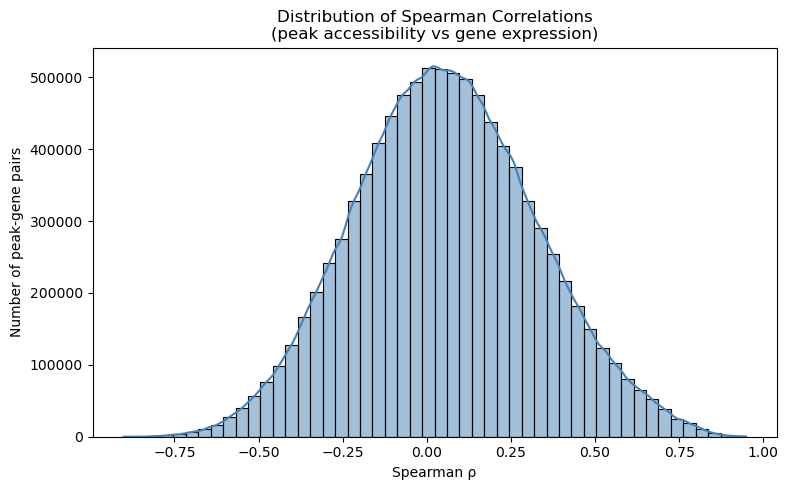

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(cor_df["spearman_rho"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Spearman Correlations\n(peak accessibility vs gene expression)")
plt.xlabel("Spearman ρ")
plt.ylabel("Number of peak-gene pairs")
plt.tight_layout()
plt.show()


**Fig. 1: Distribution of Spearman correlations (peak accessibility vs gene expression)**

The histogramm shows us that most peaks do not regulate their nearest gene. This is not really surprising considering that many assigned peaks are probably not real regulators of their assigned gene. However, the tails on both ends (ρ > 0.5 or ρ < -0.5) do show strong positive or negative correlations and most likely represent functional regulatory interactions. 

ρ > 0.5 → accessibility increases with expression → potential enhancers

ρ < -0.5 → accessibility decreases with expression → possible repressors

**analyse them separately**

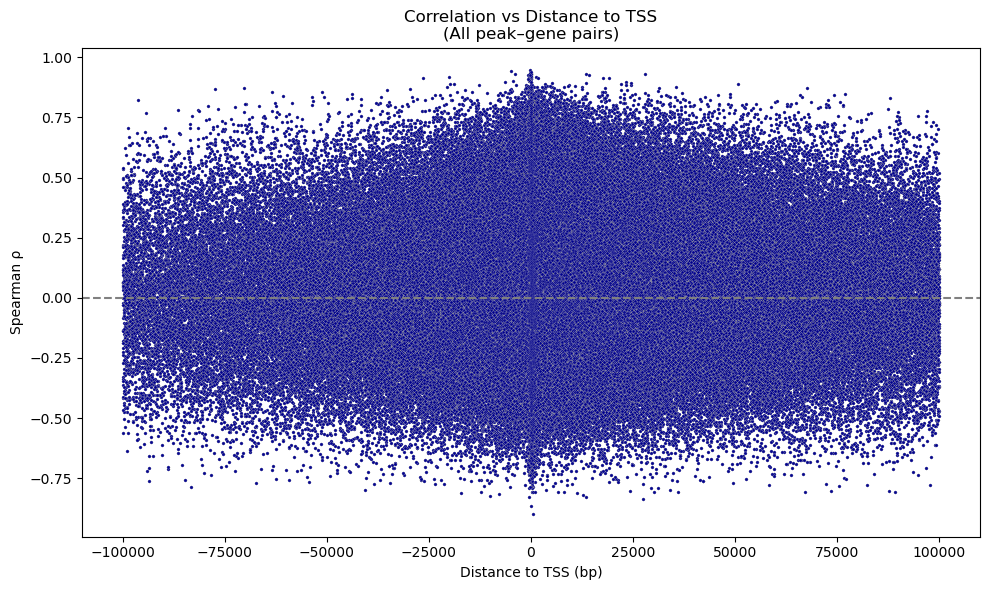

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=cor_df,
    x="signed_distance_to_tss",
    y="spearman_rho",
    alpha=0.1,
    s=5,
    color="darkblue"
)

plt.title("Correlation vs Distance to TSS\n(All peak–gene pairs)")
plt.xlabel("Distance to TSS (bp)") # distance from the peak summit to the TSS
plt.ylabel("Spearman ρ") # Spearman correlation between peak summit and expression of nearest gene
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

**Fig. 2: Correlation vs Distance to TSS (all peak-gene pairs)**

This plot confirms our expections - the most peak-gene pairs are located close to the gene-TSS, possibily proximal CREs with a direct regulatory effect on gene expression. With increasing distance to TSS the vertical spread decreases which is expected as those peaks have weaker correlations with gene expression.

# 2. Where are CREs located with respect to TSS?

We want to classify peaks based on genomic location relative to the TSS:
- promoter
- proximal enhancer
- distal enhancer
- intergenic/intronic

The first step is to classify each CRE by distance to TSS. We are going to do this qualitatively, using visual patterns to definte promoter/enhancer classes based on functional enrichment around TSS.

First, we want to plot peak counts by distance to TSS to see where peaks cluster around TSSs.

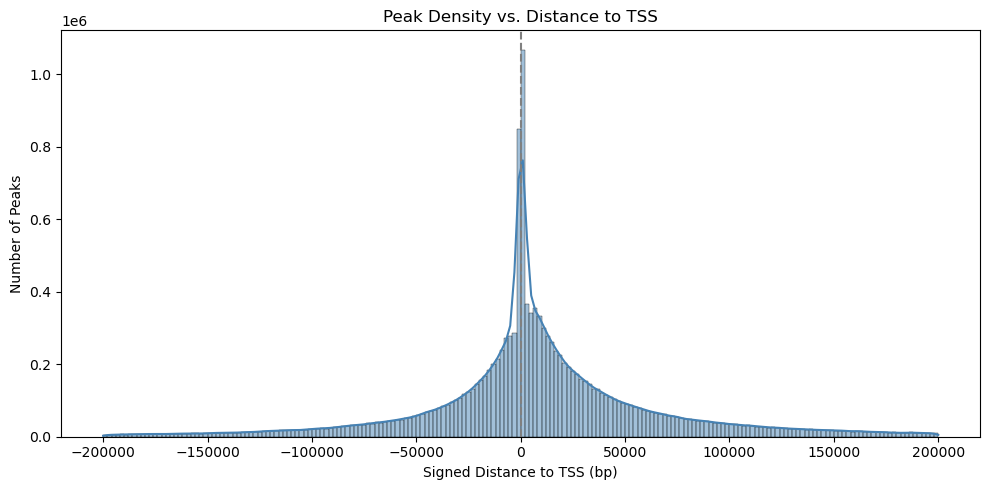

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting peak count by distance to TSS

annot = pd.read_csv("peak_to_gene_annotated.csv")

# Only keeping peaks within +/- 200 kb since ones farther away will not give us any usable information
subset = annot[annot["signed_distance_to_tss"].abs() <= 200000]

plt.figure(figsize=(10, 5))
sns.histplot(subset["signed_distance_to_tss"], bins=200, kde=True, color="steelblue")
plt.axvline(0, color='gray', linestyle='--')
plt.title("Peak Density vs. Distance to TSS")
plt.xlabel("Signed Distance to TSS (bp)")
plt.ylabel("Number of Peaks")
plt.tight_layout()
plt.show()


**Fig. 3: Peak denisity vs. distance to TSS**

The sharp spike at 0 bp shows a large number of ATAC-seq peaks that fall directly at or near the TSSs as we would expect for promoter regions. The signal density gradually decreases as distance from TSS increases suggesting that those peaks are connected to enhancers since they tend to be more distally located. 

Based on the shape of the plot, we can define some empirical regions:
- within +/- 1.000 bp from TSS: promoters (transcription start regions)
- within +/- 1.000-10.000 bp from TSS: proximal enhancers (likely near-promoter enhancers)
- within +/- 20.000 - 100.000 bp from TSS: distal enhancers (probably long-range regulation)

To further see if these cutoffs make sense, we are going to use the Spearmap ρ values from the previous task to evaluate where functional regulation is strongest. In order to be able to do that, we are going to plot correlation stregth vs distance.

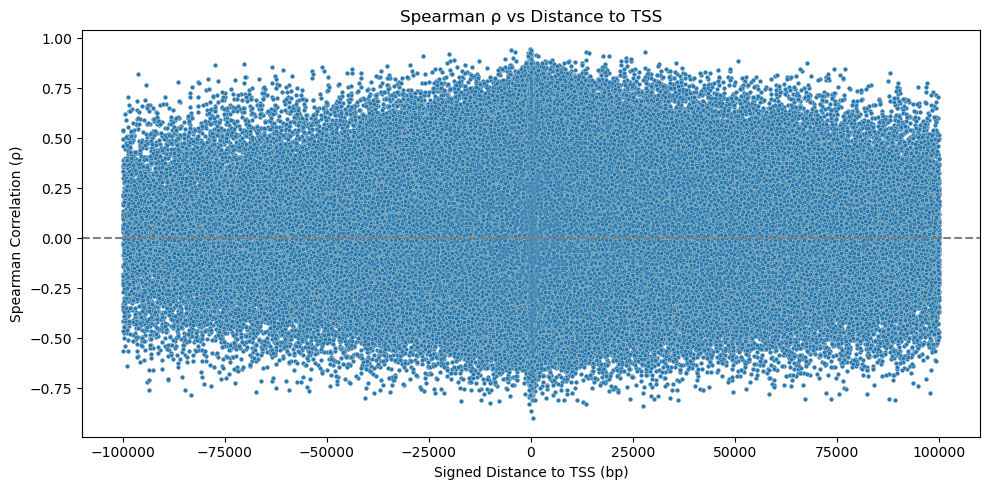

In [13]:
# Plotting correlation strength vs distance

cor_df = pd.read_csv("all_peak_gene_correlations.csv")

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=cor_df[cor_df["signed_distance_to_tss"].abs() <= 200000],
    x="signed_distance_to_tss", 
    y="spearman_rho", 
    alpha=0.1, 
    s=8
)
plt.axhline(0, linestyle="--", color="gray")
plt.title("Spearman ρ vs Distance to TSS")
plt.xlabel("Signed Distance to TSS (bp)")
plt.ylabel("Spearman Correlation (ρ)")
plt.tight_layout()
plt.show()


**Fig. 4: Spearman ρ vs distance to TSS**

In this plot, we can see again the Spearman correlation (ρ) between ATAC-seq peak accessibility and gene expression, plotted against distance to the nearest TSS.

The symmetric distribution of the plot suggests that both upstream and downstream regulatory elements can influence gene expression. Furthermore, we can observe a slightly denser cloud near +/- 20 kb suggesting promoter-proximal elements may show more consistent correlation (positive or negative) with gene expression. Beyong +/- 50 kb, the correlation range stays broad, but we can not observe any clear trend which is expected for distal enhancers that may act more variably or conditionally. 

Comparing this graphic with Fig. 3, we can not define any sharp cutoffs, but we can define empirical bins (<1 kb, 1-20 kb, >20 kb) based on peak density and behaviour. We will do that in the next step.

We are grouping peak-gene pairs into five regions based on distance to nearest TSS:
- distal enhancers
- proximal enhancers
- upstream position 
- downstream position
- promoters 

/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_34814/928417748.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = cor_df.groupby("RegionCategory")["spearman_rho"].agg(["count", "mean", "median", "std"])


                       count      mean    median       std
RegionCategory                                            
Distal Upstream      1608427  0.031196  0.027394  0.257646
Proximal Upstream    1631975  0.051679  0.045162  0.268469
Promoter             1220088  0.090852  0.089509  0.302425
Proximal Downstream  2331397  0.076501  0.070007  0.271529
Distal Downstream    2743574  0.042545  0.038862  0.260149


/var/folders/4h/4d6rt9vd0zl_794dt1wdryqr0000gn/T/ipykernel_34814/928417748.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cor_df, x="RegionCategory", y="spearman_rho", palette="pastel")


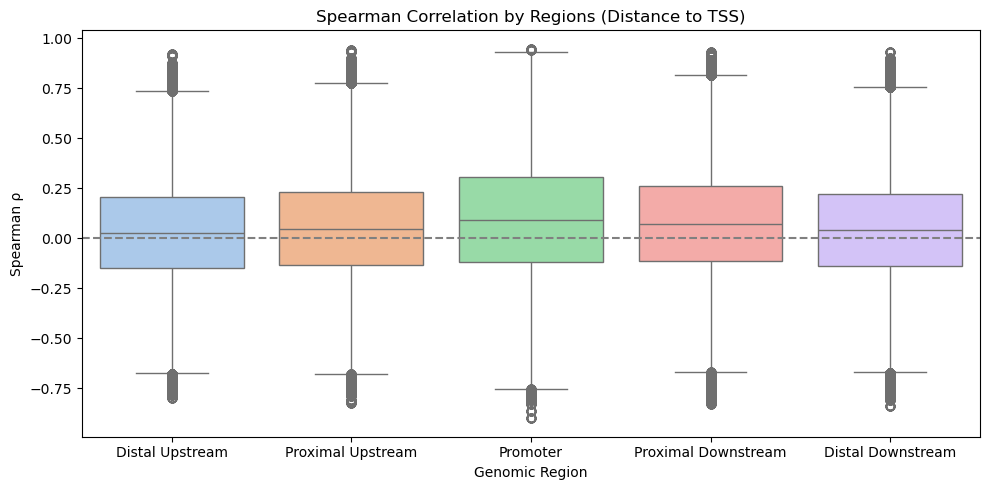

In [14]:
# Binning and summarizing correlation by TSS distance
## Loading the correlation file
import pandas as pd

cor_df = pd.read_csv("all_peak_gene_correlations.csv")

## Defining bins (up/downstream)
distance_col = "signed_distance_to_tss" if "signed_distance_to_tss" in cor_df.columns else "distance_to_tss"

### Defining bin edges and labels
bins = [-1e6, -20000, -1000, 1000, 20000, 1e6]
labels = ["Distal Upstream", "Proximal Upstream", "Promoter", "Proximal Downstream", "Distal Downstream"]

### Assigning each row to a region category
cor_df["RegionCategory"] = pd.cut(cor_df[distance_col], bins=bins, labels=labels)

## Summarizing correlation per region
summary_stats = cor_df.groupby("RegionCategory")["spearman_rho"].agg(["count", "mean", "median", "std"])
print(summary_stats)

## Plotting Spearman ρ per region
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=cor_df, x="RegionCategory", y="spearman_rho", palette="pastel")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Spearman Correlation by Regions (Distance to TSS)")
plt.xlabel("Genomic Region")
plt.ylabel("Spearman ρ")
plt.tight_layout()
plt.show()


**Table 1: Region categories (promoter, proximal downstream, proximal upstream, distal downstream, distal upstream)**

From the table we can gather that promoters and proximal regions have stronger functional links to gene expression than distal regions.

**Fig. 5: Boxplot. Spearman correlation by regions (distance to TSS)**

The boxplot shows that all regions include both positive and negative correlations, but median and spread vary. It is visible, that promoters clearly skew towards positive correlations while distal elements have broader distributions with more heterogenous functions (probably silencers or context-specific enhancers). 

In the last step, we want to connect each gene to the specific CREs that are near its TSS and show evidence of correlation. We will have a gene-centric map of regulatory elements. For that, we are going to assign distances based on the quantitative analysis and the defined cutoffs from Fig. 3 and Fig. 4. 

In [15]:
# Creating a gene-centric map of CREs

## Adding the signed distances to cor_df
if "signed_distance_to_tss" not in cor_df.columns:
    signed_distances = pd.read_csv("peak_to_gene_annotated.csv")[["peak_id", "gene_symbol", "signed_distance_to_tss"]]
    cor_df = pd.merge(cor_df, signed_distances, on=["peak_id", "gene_symbol"], how="inner")

## Defining regions based on Fig. 3 & Fig. 4
def assign_region(dist):
    if -1000 <= dist <= 1000:
        return "Promoter"
    elif -10000 <= dist < -1000:
        return "Proximal Upstream"
    elif 1000 < dist <= 10000:
        return "Proximal Downstream"
    elif -20000 <= dist < -10000:
        return "Distal Upstream"
    elif 10000 < dist <= 20000:
        return "Distal Downstream"
    else:
        return "Unassigned"

cor_df["Region"] = cor_df["signed_distance_to_tss"].apply(assign_region)

## Grouping by gene and region

### For each gene, list its peaks by region
grouped = cor_df.groupby(["gene_symbol", "Region"]).agg({
    "peak_id": list,
    "spearman_rho": list,
    "signed_distance_to_tss": list
}).reset_index()

## Saving output
grouped.to_csv("gene_regulatory_map.csv", index=False)
gene_map = pd.read_csv("gene_regulatory_map.csv")
gene_map.head()

,gene_symbol,Region,peak_id,spearman_rho,signed_distance_to_tss
0,0610005C13Rik,Distal Upstream,"['ImmGenATAC1219.peak_427236', 'ImmGenATAC1219...","[-0.238722441512202, -0.1735676353173739, -0.3...","[-14074, -14334, -15928, -16780, -17125, -1811..."
1,0610005C13Rik,Proximal Downstream,"['ImmGenATAC1219.peak_427235', 'ImmGenATAC1219...","[0.1867547187476273, 0.1867547187476273, 0.186...","[1003, 1003, 1003, 1003, 1003, 1003, 1003, 100..."
2,0610009B22Rik,Distal Downstream,"['ImmGenATAC1219.peak_75283', 'ImmGenATAC1219....","[-0.0049301577859799, 0.041506723580693, 0.288...","[17046, 14331, 10788, 17046, 14331, 10788, 170..."
3,0610009B22Rik,Distal Upstream,"['ImmGenATAC1219.peak_75292', 'ImmGenATAC1219....","[-0.0576371269475148, -0.1177606246713551, -0....","[-14432, -14889, -15224, -14432, -14889, -1522..."
4,0610009B22Rik,Promoter,"['ImmGenATAC1219.peak_75288', 'ImmGenATAC1219....","[0.1713425498459762, 0.4176245210727969, 0.542...","[214, -163, -479, 214, -163, -479, 214, -163, ..."


Task 2.iii.d) I want to see if each promoter is associated with a gene

First going to take a look at all promoters. The way we do this is to load the file where we have peaks as rows and distance to tss as a column. Then we define what a promoter is according to Kalina's findings up there and what she defined a promoter as. 

In [22]:
import pandas as pd

# Load the file that has one row per peak and its signed_distance_to_tss
annot = pd.read_csv("peak_to_gene_annotated.csv")

# Filter to ±1 kb of TSS
all_promoters = set(
    annot.loc[
        (annot["signed_distance_to_tss"] >= -1000) &
        (annot["signed_distance_to_tss"] <=  1000),
        "peak_id"
    ]
)
print("Total promoter-range peaks:", len(all_promoters))


Total promoter-range peaks: 49725


Now we are going to compare it to kalinas tables where she assigned all genes with the peaks closest to them and what kind of CRE's this peak is (f.e promoter, distal bla bla etc), along with the closest TSS to this CRE. By comparing these numbers we are gonna compare if every promoter has been assigned to a gene or not

In [23]:
# Load the gene-centric map (peak_id is a text list, so we eval it)
gene_map = pd.read_csv("gene_regulatory_map.csv")
import ast

# Pull out every peak_id listed under “Promoter”
assoc_lists = gene_map.loc[gene_map.Region == "Promoter", "peak_id"]
linked_promoters = set()
for text_list in assoc_lists:
    linked_promoters |= set(ast.literal_eval(text_list))

print("Promoters with at least one gene:", len(linked_promoters))


Promoters with at least one gene: 42081


In [24]:
missing = all_promoters - linked_promoters
if not missing:
    print("✔ Every promoter-range peak is linked to at least one gene.")
else:
    print("✘ These promoter peaks have NO gene:", missing)
    print("Count:", len(missing))


✘ These promoter peaks have NO gene: {'ImmGenATAC1219.peak_144494', 'ImmGenATAC1219.peak_472974', 'ImmGenATAC1219.peak_122168', 'ImmGenATAC1219.peak_55105', 'ImmGenATAC1219.peak_112311', 'ImmGenATAC1219.peak_480853', 'ImmGenATAC1219.peak_199535', 'ImmGenATAC1219.peak_219706', 'ImmGenATAC1219.peak_46586', 'ImmGenATAC1219.peak_37292', 'ImmGenATAC1219.peak_183923', 'ImmGenATAC1219.peak_273461', 'ImmGenATAC1219.peak_79122', 'ImmGenATAC1219.peak_178115', 'ImmGenATAC1219.peak_56811', 'ImmGenATAC1219.peak_59532', 'ImmGenATAC1219.peak_375328', 'ImmGenATAC1219.peak_246987', 'ImmGenATAC1219.peak_402182', 'ImmGenATAC1219.peak_316868', 'ImmGenATAC1219.peak_97352', 'ImmGenATAC1219.peak_117772', 'ImmGenATAC1219.peak_331338', 'ImmGenATAC1219.peak_484802', 'ImmGenATAC1219.peak_155734', 'ImmGenATAC1219.peak_205345', 'ImmGenATAC1219.peak_426159', 'ImmGenATAC1219.peak_433105', 'ImmGenATAC1219.peak_363540', 'ImmGenATAC1219.peak_428732', 'ImmGenATAC1219.peak_308942', 'ImmGenATAC1219.peak_508471', 'ImmGenAT

In [25]:
total = len(all_promoters)             # 49 725  
linked = len(linked_promoters)         # 42 081  
pct = linked / total * 100  
print(f"{linked:,}/{total:,} ({pct:.1f}%) of promoters are linked to ≥1 gene")  


42,081/49,725 (84.6%) of promoters are linked to ≥1 gene


orphan promoters lmao

Now the second task 2.iii.e) Are some promoters associated with other genes? bzw. Does any ATAC-peak in a ±1 kb “promoter” window end up correlating more strongly (or above your significance cutoff) with the expression of a gene other than the one whose TSS it sits by?

In [30]:
import pandas as pd

# 1) Get your promoter‐range peaks + their nearest gene
annot = pd.read_csv("peak_to_gene_annotated.csv")
prom = annot[ annot["signed_distance_to_tss"].between(-1000,1000) ][
    ["peak_id","gene_symbol"]
].rename(columns={"gene_symbol":"nearest_gene"})

# 2) Load the full peak×gene correlation table
cor = pd.read_csv("all_peak_gene_correlations.csv", usecols=["peak_id","gene_symbol","spearman_rho"])

# 3) For each promoter peak, find the gene with the highest |ρ|
prom_cor = cor[ cor["peak_id"].isin(prom["peak_id"]) ]
# idx of max absolute correlation per peak
idx = prom_cor.groupby("peak_id")["spearman_rho"].apply(lambda x: x.abs().idxmax())
best = prom_cor.loc[idx]

# 4) Compare “best” vs. “nearest” gene
best = best.merge(prom, on="peak_id")
mismatch = best[ best["gene_symbol"] != best["nearest_gene"] ]

print(f"{len(mismatch)}/{prom['peak_id'].nunique()} promoters link stronger to another gene")
# Optionally view a few:
mismatch.head()


0/49725 promoters link stronger to another gene


,peak_id,gene_symbol,spearman_rho,nearest_gene


### What I did, step by step

1. **Nearest-gene assignment**  
   For each promoter-range peak (±1 kb from a TSS), I noted which gene was its _nearest_ neighbor on the genome—this is our “nearest_gene.”

2. **Correlation scan**  
   I then looked at the Spearman correlation of that same peak’s accessibility with _every_ gene’s expression.

3. **Best-match gene**  
   For each promoter peak, I found the _one_ gene whose expression had the strongest absolute correlation with that peak’s accessibility—call that “best_gene.”

4. **Compare nearest vs. best**  
   If “best_gene” ≠ “nearest_gene,” then that promoter might really be functionally linked to a _different_ gene than the one it sits next to.

---

### I found **zero** mismatches

- **0 / 49 725** promoter peaks showed up as “best linked” to a _different_ gene.  
- In other words: **every** promoter peak correlates most strongly with the expression of its _genomically nearest_ gene.


Now for 2.iii.f) What is the closest associated CRE to a gene?

In [ ]:
import pandas as pd

annot = pd.read_csv("peak_to_gene_annotated.csv")
# has the columns: peak_id, gene_symbol, signed_distance_to_tss


In [36]:
annot["abs_dist"] = annot["signed_distance_to_tss"].abs()

idx = annot.groupby("gene_symbol")["abs_dist"].idxmin()
closest = annot.loc[idx, ["gene_symbol", "peak_id", "signed_distance_to_tss"]]

closest.head()
# → each row is one gene and its nearest CRE (with distance)


,gene_symbol,peak_id,signed_distance_to_tss
12201637,0610005C13Rik,ImmGenATAC1219.peak_427235,1003
1924716,0610009B22Rik,ImmGenATAC1219.peak_75289,-163
7476771,0610009E02Rik,ImmGenATAC1219.peak_263173,-25
1944762,0610009L18Rik,ImmGenATAC1219.peak_95335,-68
1919755,0610010F05Rik,ImmGenATAC1219.peak_70328,-94


this dataframe gives us one row per gene, with the peak_id of its nearest CRE and how far away it sits

here i wanna get a feel of the data:

In [37]:
closest["signed_distance_to_tss"].describe()


count    2.385300e+04
mean     1.946614e+02
std      2.016656e+04
min     -1.637530e+06
25%     -9.600000e+01
50%     -2.200000e+01
75%      1.050000e+02
max      7.853960e+05
Name: signed_distance_to_tss, dtype: float64

saving it 

In [38]:
closest.to_csv("gene_closest_CRE.csv", index=False)


In [39]:
import pandas as pd, ast

# 1) Load the gene-centric map your friend built
gene_map = pd.read_csv("gene_regulatory_map.csv")

# 2) Build a dict: peak_id → set of genes it’s assigned to
peak2genes = {}
for _, row in gene_map.iterrows():
    gene = row.gene_symbol
    peaks = ast.literal_eval(row.peak_id)      # parse the text list
    for p in peaks:
        peak2genes.setdefault(p, set()).add(gene)

# 3) Filter to CREs controlling >1 genes
multi = {p:genes for p,genes in peak2genes.items() if len(genes) > 1}

# 4) Report
print(f"{len(multi)} CREs are linked to multiple genes out of {len(peak2genes)} total peaks.")

# 5) Peek at a few examples
for p, genes in list(multi.items())[:5]:
    print(p, "→", genes)


0 CREs are linked to multiple genes out of 328809 total peaks.
